In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import files
from PIL import Image
import io
import shutil

Saving Data.zip to Data (1).zip
Pixel size? (e.g., 16 for 16x16) 64
Number of colors? (e.g., 16, 32, 64) 32


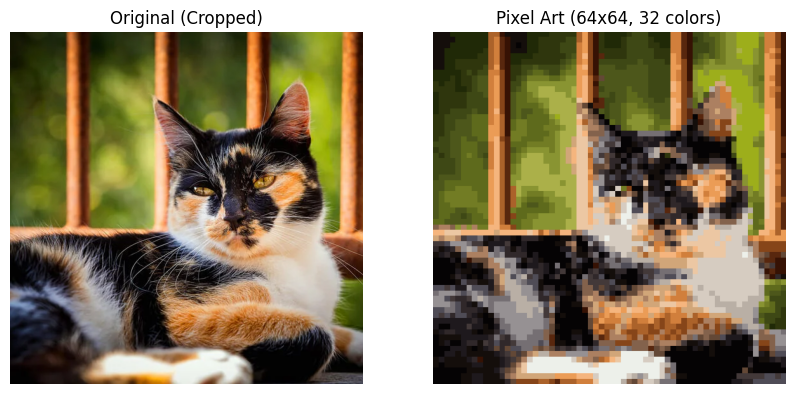

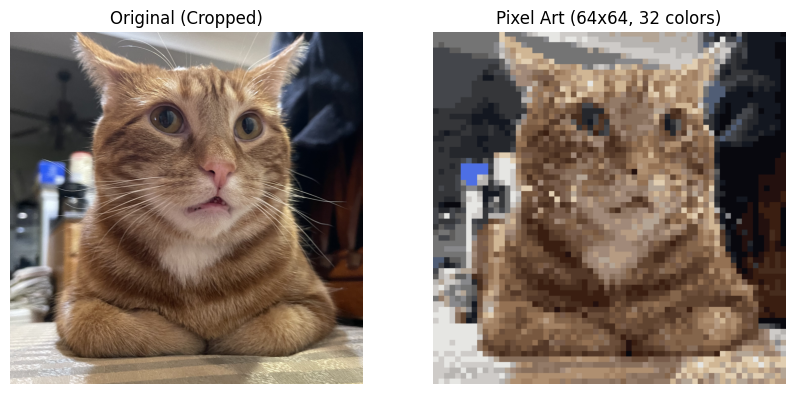

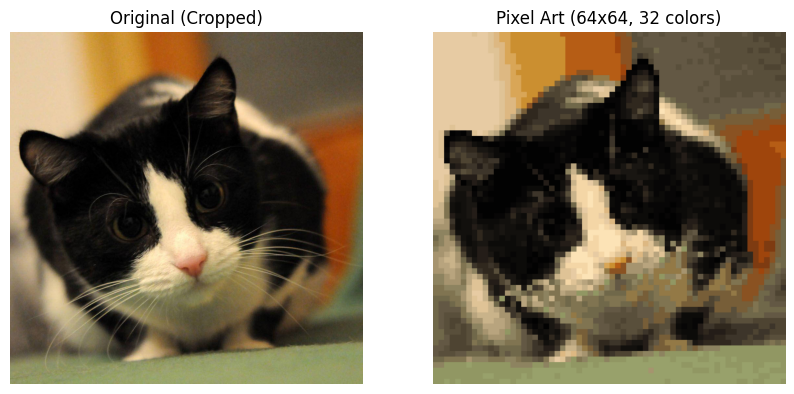

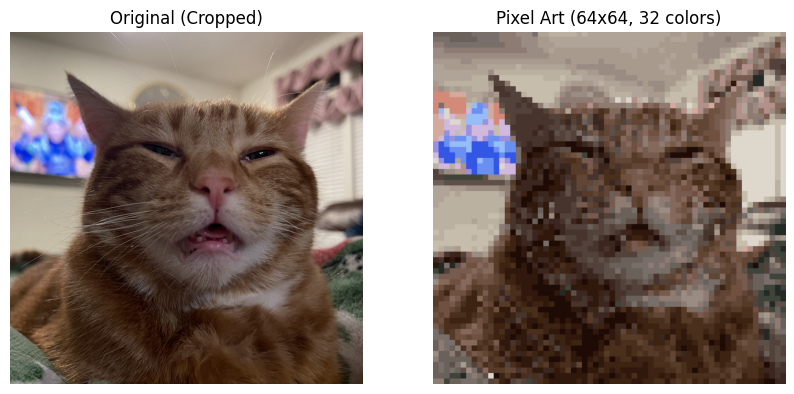

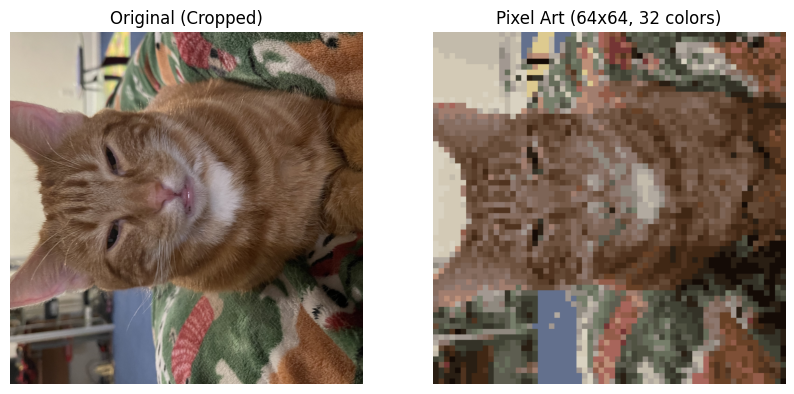

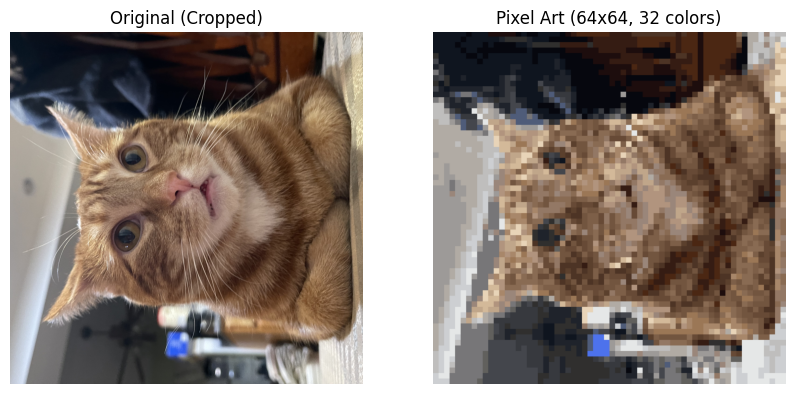

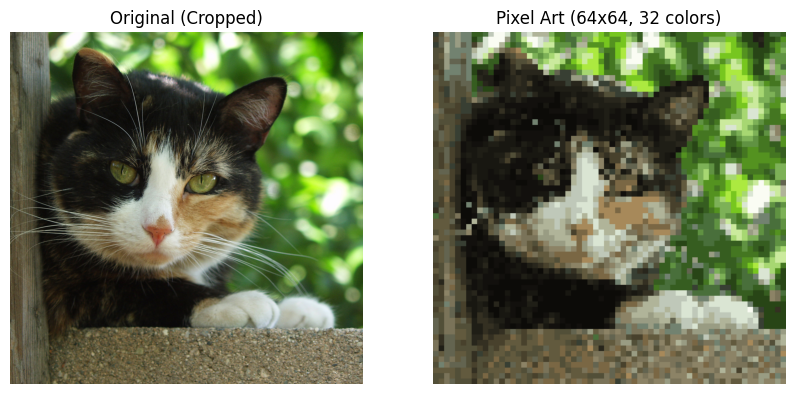

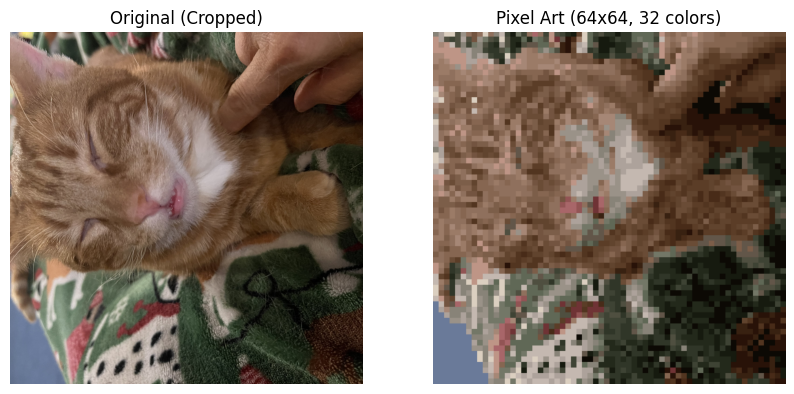

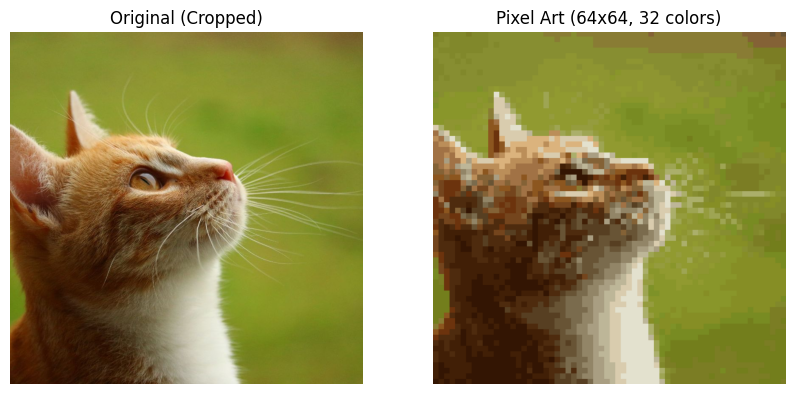

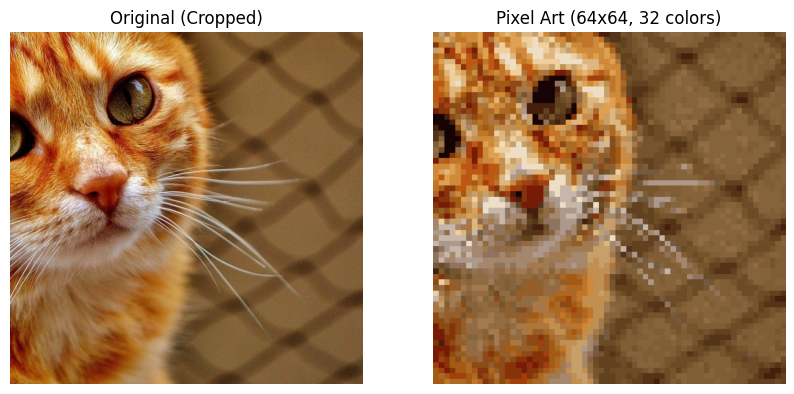

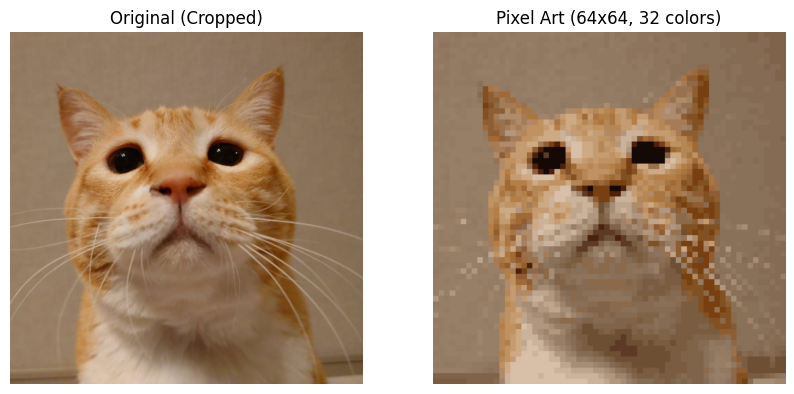

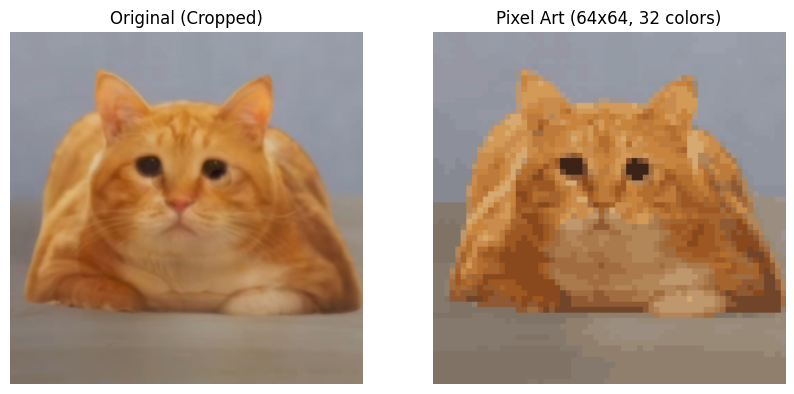

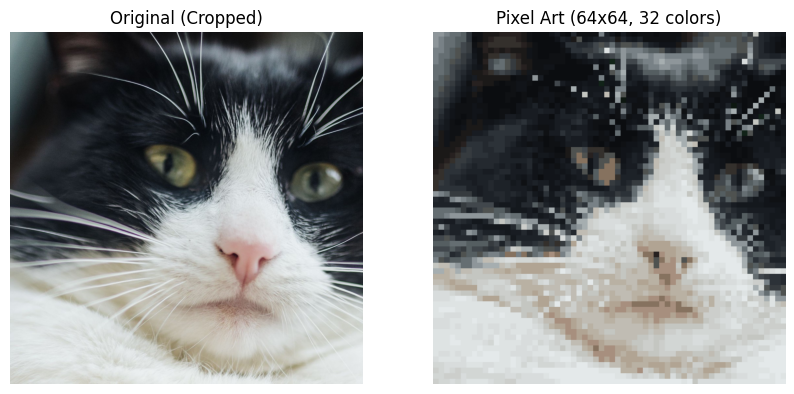

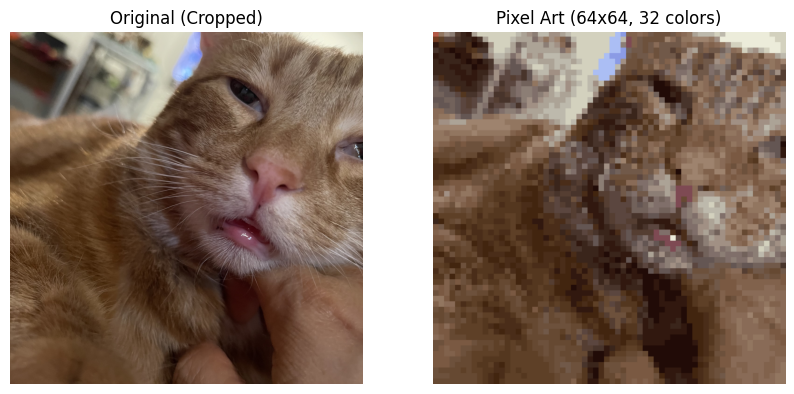

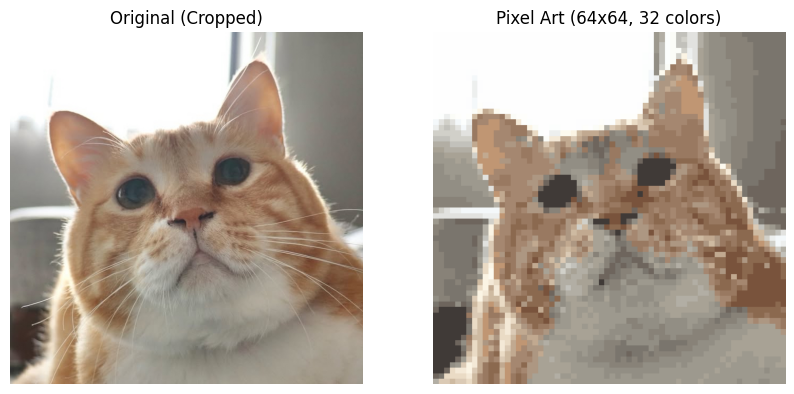

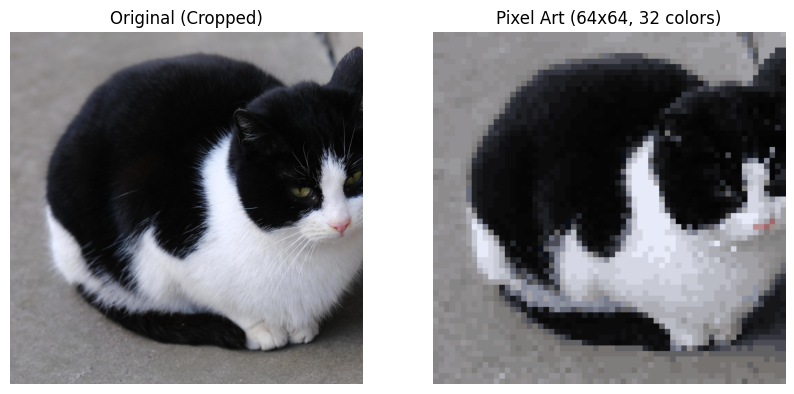

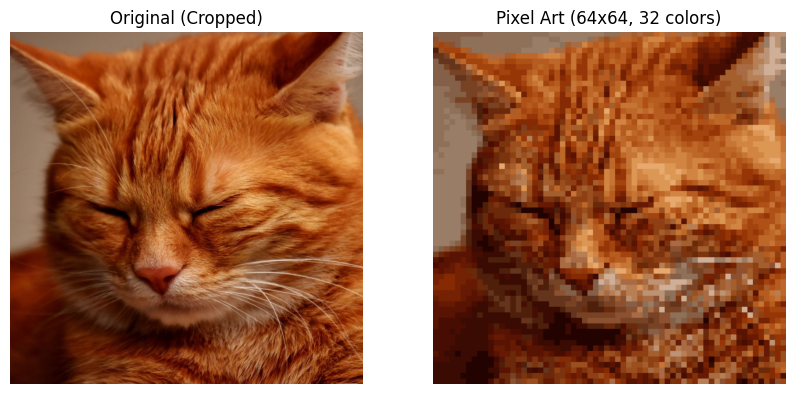

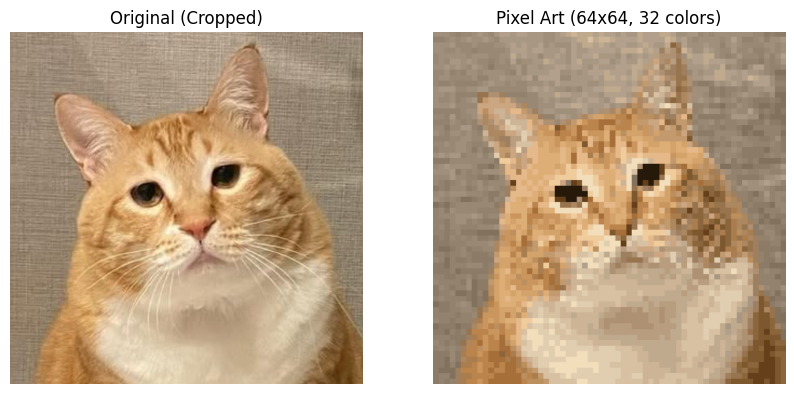

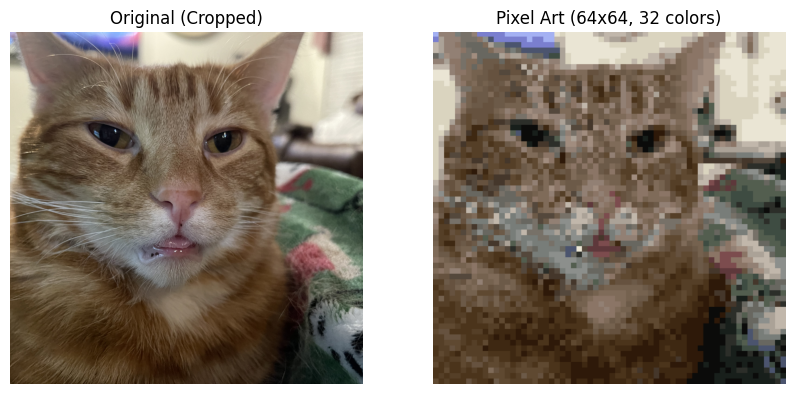

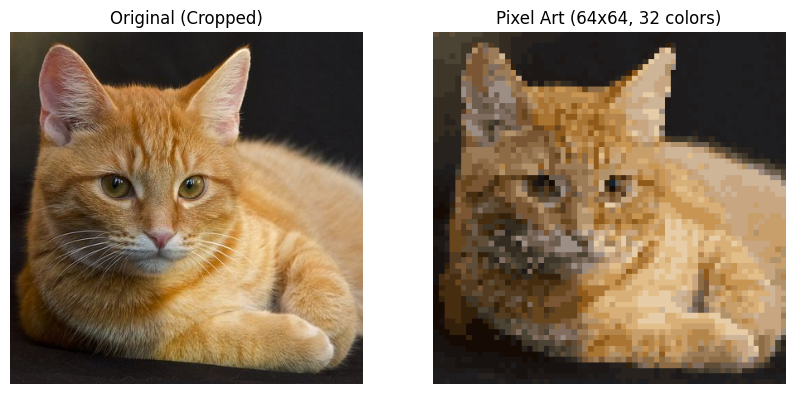

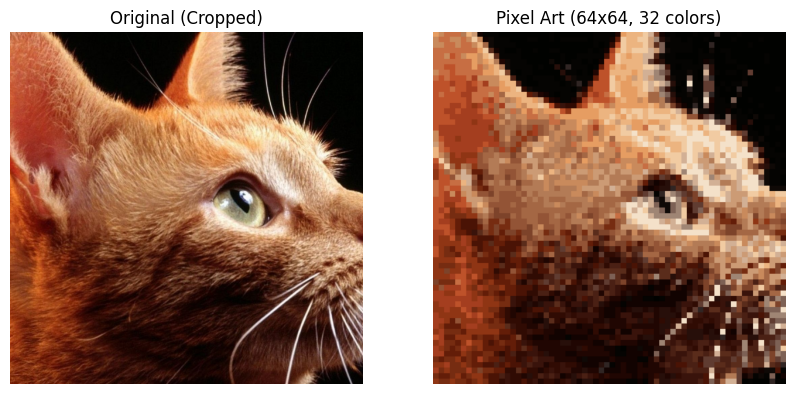

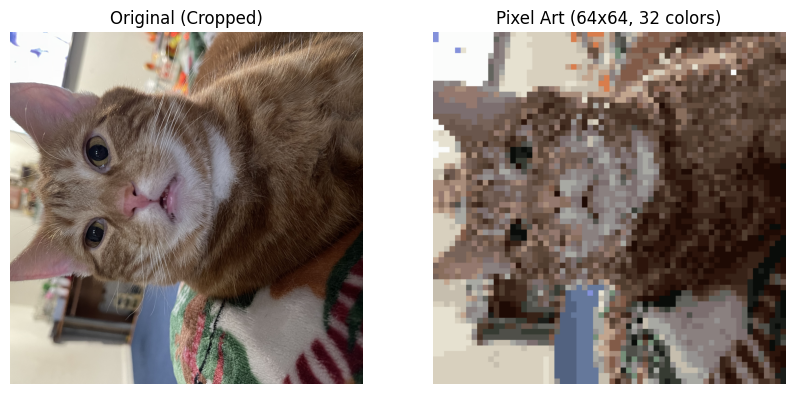

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# Upload a ZIP with images
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

# Extract ZIP contents
extract_folder = "unzipped_images"
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Get all image files (ignoring random files)
image_files = [f for f in os.listdir(extract_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Ask for pixel size and number of colors
pixel_size = int(input("Pixel size? (e.g., 16 for 16x16) "))
num_colors = int(input("Number of colors? (e.g., 16, 32, 64) "))

# Function to process an image (crop → pixelate → color quantize)
def process_image(image_path, pixel_size, num_colors):
    img = Image.open(image_path).convert("RGB")
    img_cv = np.array(img)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

    # Crop to square (centered)
    h, w, _ = img_cv.shape
    size = min(h, w)
    x1, x2 = (w - size) // 2, (w + size) // 2
    y1, y2 = (h - size) // 2, (h + size) // 2
    img_square = img_cv[y1:y2, x1:x2]

    # Resize down and up for pixelation
    img_small = cv2.resize(img_square, (pixel_size, pixel_size), interpolation=cv2.INTER_LINEAR)
    img_pixel = cv2.resize(img_small, (size, size), interpolation=cv2.INTER_NEAREST)

    # Reduce colors (K-Means clustering)
    def quantize_colors(image, k):
        Z = image.reshape((-1, 3)).astype(np.float32)
        _, labels, centers = cv2.kmeans(Z, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 10, cv2.KMEANS_RANDOM_CENTERS)
        return centers[labels.flatten()].reshape(image.shape).astype(np.uint8)

    img_pixel = quantize_colors(img_pixel, num_colors)

    return img_square, img_pixel  # Original cropped + pixelated

# Process all images
output_folder = "processed_images"
os.makedirs(output_folder, exist_ok=True)

for img_file in image_files:
    img_path = os.path.join(extract_folder, img_file)

    try:
        original, pixel_art = process_image(img_path, pixel_size, num_colors)

        # Show images (for fun)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original (Cropped)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(pixel_art, cv2.COLOR_BGR2RGB))
        plt.title(f"Pixel Art ({pixel_size}x{pixel_size}, {num_colors} colors)")
        plt.axis("off")
        plt.show()

        # Save processed image
        save_path = os.path.join(output_folder, f"pixel_{img_file}")
        Image.fromarray(cv2.cvtColor(pixel_art, cv2.COLOR_BGR2RGB)).save(save_path)

    except Exception as e:
        print(f"Couldn't process {img_file}: {e}")

# Zip processed images
zip_output = "pixel_art_images.zip"
shutil.make_archive("pixel_art_images", 'zip', output_folder)

# Download ZIP
files.download(zip_output)
